## Camera Calibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#### Steps used in calulating width of square
- Grayscale and Contrast Adjustment
- Blurring the image to fill up smaller gaps
- Thresholding
- Edge Detection
- Measuring the side of sqaure
##### Every function below corresponds to some of the operations mentioned above, and all these are orchestrated by another function which can be seen below

In [2]:
def masker_rgb(img,kernel):
    img_ = np.zeros(img.shape)
    kx,ky = kernel.shape
    kx,ky = int(kx/2),int(ky/2)
    for i in range(kx,img.shape[0]-kx):
        for j in range(ky,img.shape[1]-ky):
            select = img[i-kx:i+kx+1,j-ky:j+ky+1]
            img_[i][j] = np.sum(kernel * select)
    return img_.astype(int)

def thresholder_invert(img,t):
	for i in range(img.shape[0]):
		for j in range(img.shape[1]):
			if img[i][j] > t:
				img[i][j] = 0
			else:
				img[i][j] = 255

	return img

def contrast_equilization(img,fmin,fmax):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            x = int((img[i][j]-fmin)*255/(fmax-fmin))
            if x<=255 and x>=0:
                img[i][j] = x
            elif x>255:
                img[i][j] = 255
            else:
                img[i][j] = 0
    return img

def contrast_adjustment(img,percent):
    return contrast_equilization(img, int(127-((100-percent)*127/200)),
                                 int(127+((100-percent)*127/200)))
    


In [3]:
def masker(img,ker):
    img_ = np.zeros(img.shape)
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]-1):
            img_[i][j] = img[i][j-1]*ker[0] + img[i][j+1]*ker[2] + img[i][j]*ker[1]
    return img_.astype(int)

def sqaureFinder(img):
    edged_img = masker(img.copy(),np.array([-1,2,1]))
    sqs,l,w,st,flag = [{'start':0,"length":0,"width":0}],[],[],[],False
    for i in range(edged_img.shape[0]-1):
        for j in range(edged_img.shape[1]-1):
            if img[i][j].any() != img[i][j+1].any():
                w.append(j)
            if img[i][j].any() != img[i+1][j].any():
                l.append(i)
            if img[i][j].any() != img[i+1][j+1].any():
                if flag==False:
                    st.append([i,j])
                    flag = !flag
                else:
                    flag =!flag
    #st = np.array(st[0])+2
    #return {'length':l_[1]-l_[0],'width':w_[1]-w_[0],'start':st}
    return (l,w)

In [4]:
def measure_pixels(path):
    original_img = cv2.imread(path)
    original_img = cv2.cvtColor(original_img,cv2.COLOR_BGR2GRAY)
    plt.imshow(original_img,cmap='gray')
    plt.title("Original Image")
    plt.show()
    
    
    img = thresholder_invert(masker_rgb(contrast_adjustment(original_img.copy(),50),
                                        np.ones([5,5])/25)[10:-10,10:-10],150)
    
    square = sqaureFinder(img)
    
    l,w = square
    return np.abs(np.median(l[0:int(len(l)/2)]) - np.median(l[int(len(l)/2):]))

Trying out the Working for a sample image.

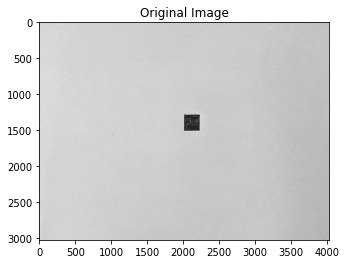

224.0

In [5]:
measure_pixels('Sqaure_from_phone.jpg')

### Performing on Actual Images (NO CROPPING)
There was the error in plotting of the Graph, please ignore

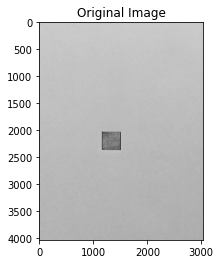

156.0


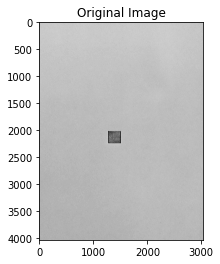

110.5


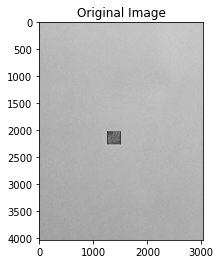

114.0


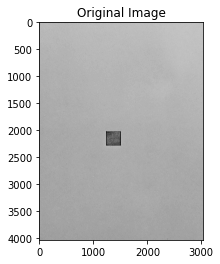

126.0


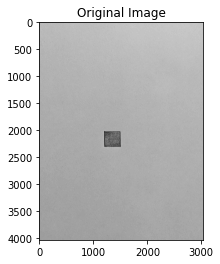

142.0


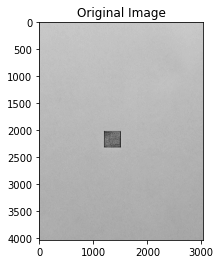

142.0


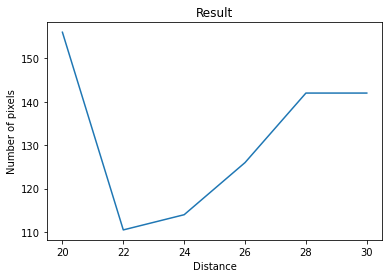

In [6]:
data = {'file':['measuring/S1.jpg','measuring/S2.jpg','measuring/S3.jpg',
               'measuring/S4.jpg','measuring/S5.jpg','measuring/S6.jpg'],
        'distance':[20,22,24,26,28,30],'pixels':[]}
for i in range(len(data['file'])):
    data['pixels'].append(measure_pixels(data['file'][i]))
    print(data['pixels'][i])
plt.plot(data['distance'],data['pixels'])
plt.title("Result")
plt.xlabel("Distance")
plt.ylabel("Number of pixels")
plt.show()

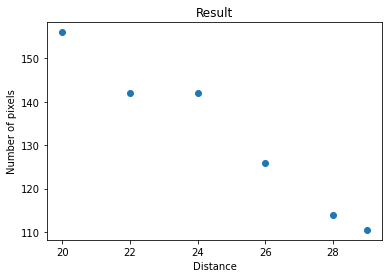

In [9]:
data['distance'] = [20,29,28,26,24,22]
plt.scatter(data['distance'],data['pixels'])
plt.title("Result")
plt.xlabel("Distance")
plt.ylabel("Number of pixels")
plt.show()

from the above observation, I realized that, I have not noted the distance at 24cm. properly, hence we Ignore that point while considering
### Performing Same on Cropped Image

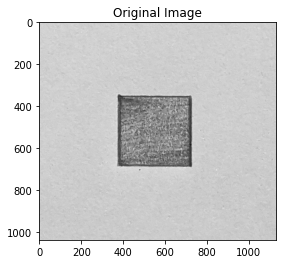

156.0


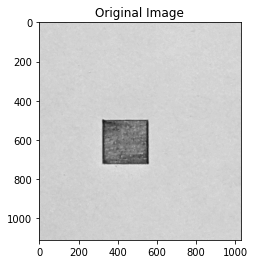

110.0


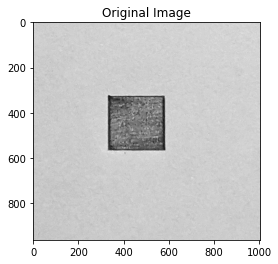

115.0


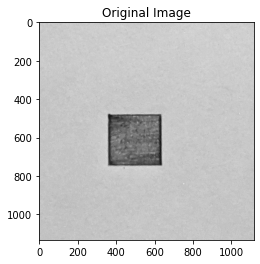

126.0


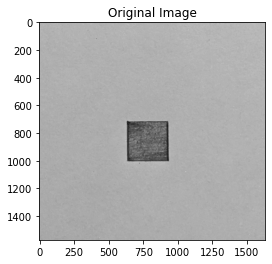

142.0


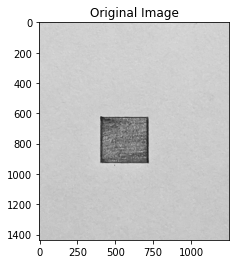

142.0


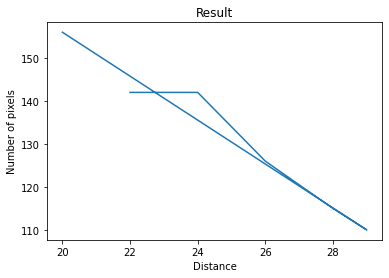

In [10]:
data = {'file':['measuring2/S1.jpg','measuring2/S2.jpg','measuring2/S3.jpg',
               'measuring2/S4.jpg','measuring2/S5.jpg','measuring2/S6.jpg'],
        'distance':[20,29,28,26,24,22],'pixels':[]}
for i in range(len(data['file'])):
    data['pixels'].append(measure_pixels(data['file'][i]))
    print(data['pixels'][i])
plt.plot(data['distance'],data['pixels'])
plt.title("Result")
plt.xlabel("Distance")
plt.ylabel("Number of pixels")
plt.show()

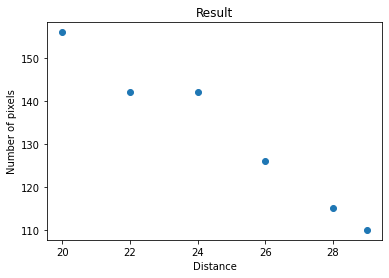

In [11]:
plt.scatter(data['distance'],data['pixels'])
plt.title("Result")
plt.xlabel("Distance")
plt.ylabel("Number of pixels")
plt.show()

As mentioned earlier, We ignore the point due to some acquisition error and is removed from the observations below

In [24]:
x,y = data['distance'],data['pixels']
x.remove(x[4])
y.remove(y[4])

### Performing Linear Regression on the Data

In [31]:
from scipy import stats
m,c,a,b,z = stats.linregress(x,y)

In [32]:
def linreg_model(x):
    return (m*x)+c

At Distances	 [24 25 21]
1cm = 		 [135.6974359  130.58461538 151.03589744]


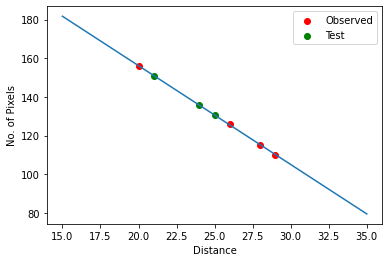

In [41]:
#Let the new distance of Camera be [24cm,25cm,21cm]

x_test = np.array([24,25,21])
y_test = linreg_model(x_test)
print("At Distances\t",x_test)
print("1cm = \t\t",y_test)

x_ = np.linspace(15,35,100)
plt.plot(x_,linreg_model(x_))
plt.scatter(x,y,color='red',label='Observed')
plt.scatter(x_test,y_test,color='green',label='Test')
plt.xlabel('Distance')
plt.ylabel("No. of Pixels")
plt.legend()
plt.show()

Hence we can now say that the camera is calibrated successfully